## <center> Q-Learning - Discrete Actions</center>


In [1]:
from IPython.display import clear_output
import time
import gym
import numpy as np
import matplotlib.pyplot as plt

### PART 1: 

Setting up Frozen Lake Environment

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

    S | F | F | F
    - - - - - - -
    F | H | F | H
    - - - - - - -
    F | F | F | H
    - - - - - - -
    H | F | F | G  

- S: starting point, safe 
- F: frozen surface, safe)
- H: hole, fall to your doom)
- G: goal, where the frisbee is located

#### Environment set up

In [2]:
from gym.envs.registration import register

try:

    register(
        id='FrozenLakeNotSlippery-v0', # make sure this is a custom name!
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100, # if goal not completed stops after this number of episodes
        reward_threshold=.8196, # optimum = .8196 --> not useful for binary goals
    )
except:
    print('You probably ran this cell twice, accidentally trying to register a new env with the same id twice.')
    print("Either change the id, or just continue, knowing your id was already registered")

**Random actions run**

In [3]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
env.reset()

for _ in range(5):
    clear_output(wait=True) # Clears the previous output
    a = env.render(mode="ansi") 
    print(a)
    action = env.action_space.sample()  
    env.step(action) 
    time.sleep(0.5)
env.close()  

  (Up)
SFFF
FHFH
FFFH
HFFG



----
### PART 2: 

Creating the Q-Learning Table

Now that we validated the functionality of our function it is time to move on with the Q-Learning algorithm. 

Recall our Table is essentially a mapping of all possible state, action pairs and the expected reward for taking an action at a particular state that we will keep updating.


$$Q(s_t,a_t)$$

For our simple discrete Frozen Lake problem, this means we have 4 actions for columns, and 16 possible states (player location on the 4 by 4 grid). So our table will look like:

<table style="width:100%">
  <tr>
      <th></th>
    <th>A0 - LEFT</th>
    <th>A1 - DOWN</th>
    <th>A2 - RIGHT</th>
    <th>A3 - UP</th>
  </tr>
  <tr>
    <td><strong>State 0</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
  <tr>
      <td><strong>State 1</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
    <tr>
      <td><strong>State ...</strong></td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
        <td>...</td>
  </tr>
    <tr>
      <td><strong>State 15</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
        <td>Q(s,a)</td>
  </tr>
</table>

In [4]:
action_size = env.action_space.n
state_size = env.observation_space.n

**Initial Q-Table**

In [5]:
# Start with very small values for all our Q(s,a)
q_table = np.zeros([state_size, action_size])
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [6]:
q_table.shape

(16, 4)

#### PART 2.1:

**Hyperparameters**

The Q-Learning update functions will require hyperparameters. we'll define them here. Often the best place to choose a good starting value is reading publications or through experimentation. Unfortunately, its very difficult to give general advice, as most environments are radically different to each other, and often hyperparameter tuning is required.


In [7]:
# It is common to leave Hyperparameters in ALL CAPS to easily locate them

EPOCHS = 20000  # number of epochs/episodes to train for
ALPHA = 0.8 # aka the learning rate
GAMMA = 0.95 # aka the discount rate

**Exploration vs. Exploitation Parameters**

Basically how fast do we reduce epsilon. Reduce too fast, agent won't have enough time to learn. Reduce too slow, you're wasting time picking random actions. Key here is that these value help balance exploration (random choice) versus explotation (always picking what works for that Q(s,a). It's a tough balance!

In [8]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

#### PART 2.2:
Q-Table Update Functions Methodology

Now it is time to dive into the training / Q-Table update methodology. First we will define some functions needed for training phase:

1. Action selection:

* epsilon_greedy_action_selection: Is used to implement the epsilon greedy action selection routine.
* compute_next_q_value: Computes the next Q-Values according to the formula from the lecture
* reduce_epsilon: Reduces the $\epsilon$ used for the epsilon greedy algorithm

**1. FUNCTION TO SELECT AN ACTION**

If we simply always select the argmax() Q-table value during training, we'll most likely get stuck in an explotation loop, so we'll use a random value to randomly select an action from time to time, helping the model explore, rather than exploit.

In [9]:
def action_selection(epsilon, q_table, discrete_state):
    """
    Returns an action for the agent. Note how it uses a random number to decide on exploration 
    versus explotation trade-off.
    """
    
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]

        # Index of highest action for state
        action = np.argmax(state_row, axis=0)
            
    # EXPLORATION, USE A RANDOM ACTION
    else:
        action = env.action_space.sample()
        
    return action

**2. FUNCTION FOR Q_VALUE COMPUTATION**


$$Q(s,a) \gets (1-\alpha)*Q(s,a) + \alpha*[R(s,a) + \gamma*\max_{a}Q(s_{t+1}, a)]$$

Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.

In [10]:
def q_update(old_q_value, reward, next_optimal_q_value):
    new_q = (1-ALPHA)*old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value)
    return new_q

**3. FUNCTION TO REDUCE EPSILON**

As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an square to another square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.

$$ \epsilon = \epsilon_{min} + (\epsilon_{max} - \epsilon_{min})*e^{-\lambda*\tau}$$

- $\lambda$: decay rate
- $\tau$: epoch

In [11]:
def reduce_epsilon(epsilon,epoch):
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)
    return epsilon

#### PART 2.3:

Training of Agent and Updating Q-Table

In [12]:
# Reset just in case
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [13]:
# List of rewards
rewards = []

# Play 20k games
for episode in range(EPOCHS):

    # Reset the environment
    env = gym.make("FrozenLakeNotSlippery-v0")
    # To visualize the whole traninig, change render_mode to "human" --> takes a lot of time
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = action_selection(epsilon, q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
  
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Update q value
        q_table[state,action] = q_update(old_q_value, reward, next_optimal_q_value)

        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state

    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)


env.close()

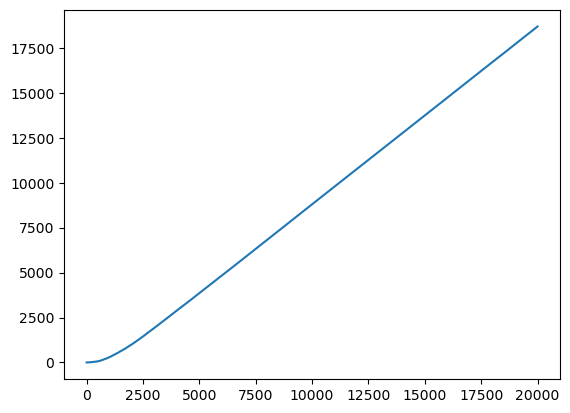

In [14]:
plt.plot(range(EPOCHS),np.cumsum(rewards))

In [15]:
q_table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

#### PART 2.4:
Using Learned Q Table Results

In [16]:
env = gym.make("FrozenLakeNotSlippery-v0")
state = env.reset()

for _ in range(100):
    a = env.render(mode="ansi") 
    print(a)
    
    action = np.argmax(q_table[state])  # and chose action from the Q-Table
    state, reward, done, info = env.step(action) # Finally perform the action

    time.sleep(1)
    clear_output(wait=True)
    
    if done:
        break

env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG



----
### Part 3

Q-Learning algorithm class programming

In [17]:
class Q_Learning:
    def __init__(self, gamma, epsilon, min_epsilon, epsilon_decay, n_actions, n_states):
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.n_states = n_states
        self.alpha = 0

        self.Q = np.zeros([self.n_states, n_actions])
        self.counts = np.zeros([self.n_states, n_actions])


    def action_selection(self, observation):
        """
        Returns an action for the agent. Note how it uses a random number to decide on exploration 
        versus explotation trade-off.
        """
        random_number = np.random.random()
        
        # EXPLOITATION, USE BEST Q(s,a) Value
        if random_number > self.epsilon:
            # Action row for a particular state
            state_row = self.Q[observation,:]
            # Index of highest action for state
            action = np.argmax(state_row, axis=0)

        # EXPLORATION, USE A RANDOM ACTION
        else:
            action = np.random.choice(self.action_space)
            
        return action

    def alpha_count(self,s,a):
        self.counts[s,a] += 1
        self.alpha = 1/self.counts[s,a]
    
    def reduce_epsilon(self,epoch):
        if self.epsilon > self.min_epsilon:
            self.epsilon = self.min_epsilon + (1. - self.min_epsilon)*np.exp(-self.epsilon_decay*epoch)
    
    def learn(self, state, state_, action, reward):
        self.Q[state, action] = self.alpha*(reward + self.gamma*np.amax(self.Q[state_, :], axis=0) - self.Q[state, action])


In [18]:
# List of rewards
rewards = []
Q = []
agent = Q_Learning(GAMMA, max_epsilon, min_epsilon, decay_rate, action_size, state_size)

# Play 20k games
for episode in range(EPOCHS):

    # Reset the environment
    env = gym.make("FrozenLakeNotSlippery-v0")
    # To visualize the whole traninig, change render_mode to "human" --> takes a lot of time
    state = env.reset()
    done = False
    total_rewards = 0
    
    
    while not done:
        action = agent.action_selection(state)
        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        agent.alpha_count(state, action)

        # Learn step
        agent.learn(state, new_state, action, reward)

        # Our new state is state
        state = new_state

    episode += 1
    Q = agent.Q
    # Reduce epsilon (because we need less and less exploration)
    agent.reduce_epsilon(episode)
    rewards.append(total_rewards)


env.close()

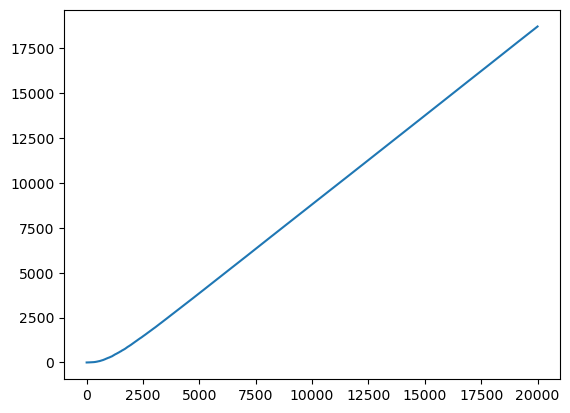

In [19]:
plt.plot(range(EPOCHS),np.cumsum(rewards))

In [20]:
Q

array([[ 1.17057844e-27,  6.04793413e-25,  6.04867426e-25,
         1.12211264e-27],
       [ 2.58069943e-27,  0.00000000e+00,  5.70960481e-21,
         2.94552283e-23],
       [ 3.89829043e-23,  5.21784556e-17,  3.88462927e-21,
         3.42198579e-19],
       [ 6.42710130e-19,  0.00000000e+00, -1.38419973e-17,
        -3.79142202e-18],
       [ 2.65002984e-23,  7.32429463e-21,  0.00000000e+00,
         3.84642430e-27],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  4.72746515e-13,  0.00000000e+00,
         5.76489725e-19],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.59666992e-19,  0.00000000e+00,  8.65846207e-17,
         3.47499546e-23],
       [ 5.84041412e-19,  1.00138036e-12,  1.00110606e-12,
         0.00000000e+00],
       [ 6.71305779e-15,  4.18348735e-09,  0.00000000e+00,
         3.31103916e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
      

In [21]:
env = gym.make("FrozenLakeNotSlippery-v0")
state = env.reset()

for _ in range(100):
    a = env.render(mode="ansi") 
    print(a)
    
    action = np.argmax(Q[state])  # and chose action from the Q-Table
    state, reward, done, info = env.step(action) # Finally perform the action

    time.sleep(1)
    clear_output(wait=True)
    
    if done:
        break

env.close()

  (Down)
SFFF
FHFH
FFFH
HFFG

